<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/221019_spikepathway_SMipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make a Spikeed Augmentaion

In [1]:
import numpy as np
# I will spike the channel divided into four hemispheres.

channel_list = [0,1,3,5,6,8,9,15,16,18,19,21,23] # 0: Non-spike
np.random.choice(channel_list,20) # randomly spike for 4 channels


array([ 1, 19, 19, 23, 21, 15, 18,  8,  3, 19,  8, 19, 15,  8, 23,  1,  3,
        8,  6,  1])

Plot The RBF Matrix

In [2]:
def RBF(spiked_ch,scale,beta):
  n = len(spiked_ch)
  noise = np.zeros((n,25))
  for i in range(n):
    if spiked_ch[i] == 0:
      continue
    else:
      for j in range(25):
        y = j//5 - spiked_ch[i]//5
        x = j%5 - spiked_ch[i]%5
        noise[i,j] = scale*np.exp(-beta*(x**2 + y**2))
  return noise

In [3]:
import time
st= time.time()
ch = np.random.choice(channel_list, 2)
a = RBF(ch,1,0.5)
et = time.time()
print(et-st)
print(ch)

0.0007796287536621094
[ 5 21]


In [4]:
a

array([[6.06530660e-01, 3.67879441e-01, 8.20849986e-02, 6.73794700e-03,
        2.03468369e-04, 1.00000000e+00, 6.06530660e-01, 1.35335283e-01,
        1.11089965e-02, 3.35462628e-04, 6.06530660e-01, 3.67879441e-01,
        8.20849986e-02, 6.73794700e-03, 2.03468369e-04, 1.35335283e-01,
        8.20849986e-02, 1.83156389e-02, 1.50343919e-03, 4.53999298e-05,
        1.11089965e-02, 6.73794700e-03, 1.50343919e-03, 1.23409804e-04,
        3.72665317e-06],
       [2.03468369e-04, 3.35462628e-04, 2.03468369e-04, 4.53999298e-05,
        3.72665317e-06, 6.73794700e-03, 1.11089965e-02, 6.73794700e-03,
        1.50343919e-03, 1.23409804e-04, 8.20849986e-02, 1.35335283e-01,
        8.20849986e-02, 1.83156389e-02, 1.50343919e-03, 3.67879441e-01,
        6.06530660e-01, 3.67879441e-01, 8.20849986e-02, 6.73794700e-03,
        6.06530660e-01, 1.00000000e+00, 6.06530660e-01, 1.35335283e-01,
        1.11089965e-02]])

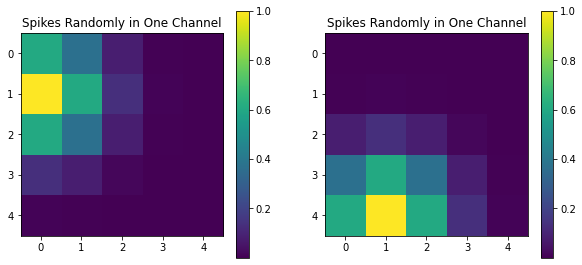

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

plt.subplot(2, 2, 1)
data = np.reshape(a[0],(5,5))
plt.imshow(data)
plt.title('Spikes Randomly in One Channel')
cbar = plt.colorbar()

plt.subplot(2, 2, 2)
data = np.reshape(a[1],(5,5))
plt.imshow(data)
plt.title('Spikes Randomly in One Channel')
cbar = plt.colorbar()

plt.savefig('spike_image_(2,1).png',bbox_inches = 'tight')
plt.show()


In [6]:
class spiked_channels():
  def __init__(self, data, scale, beta):
      self.data = data # batch_size, channels, times
      self.scale = scale
      self.beta = beta
      self.batch_size, self.channels, self.times = data.shape
     
  def RBF(self,spiked_ch):
      n = len(spiked_ch)
      noise = np.zeros((n,25))
      for i in range(n):
        if spiked_ch[i] == 0:
          continue
        else:
          for j in range(25):
            y = j//5 - spiked_ch[i]//5
            x = j%5 - spiked_ch[i]%5
            noise[i,j] = self.scale*np.exp(-self.beta*(x**2 + y**2))
      return noise #[batch_size, 25]


  def one_hot_1020sys(self,spiked_ch):
      labels = []
      for i in range(len(spiked_ch)):
        if spiked_ch[i] == 0: # Non-spike
          labels.append([1,0,0,0,0]) 

        elif spiked_ch[i] in [3,8,9]:# the 1rd quadrant
          labels.append([0,1,0,0,0])

        elif spiked_ch[i] in [18,19,23]:# the 2rd quadrant
          labels.append([0,0,1,0,0])

        elif spiked_ch[i] in [15,16,21]:# the 3rd quadrant
          labels.append([0,0,0,1,0])

        elif spiked_ch[i] in [1,5,6]:# the 4rd quadrant
          labels.append([0,0,0,0,1])
        
      labels = np.array(labels)
      return labels



  def forward(self):
      
      if self.channels == 19: # 10-20 system, 19channels
        channel_list = [0,1,3,5,6,8,9,15,16,18,19,21,23] # 0: Non-spike
        spiked_ch = np.random.choice(channel_list,self.batch_size) # randomly spike for batchsize channels
        
        noise = self.RBF(spiked_ch)
        noise = np.expand_dims(noise,-1) #[batch_size, 25] --> [batch_size, 25,1]
        noise = noise*np.ones((1,self.times))  #[batch_size, 25,1] --> [batch_size, 25,times]
        
        # add the noise, data channels oreder is different noise channels order
        self.data[:,2:17,:] += noise[:,5:20,:]  # add the noise to F7~T6 channels
        self.data[:,0,:] += noise[:,1,:] #add the noise to Fp1 channels
        self.data[:,1,:] += noise[:,3,:] #add the noise to Fp2 channels
        self.data[:,17,:] += noise[:,21,:] #add the noise to O1 channels
        self.data[:,18,:] += noise[:,23,:] #add the noise to O2 channels
        
        labels = self.one_hot_1020sys(spiked_ch)

      elif self.channels == 17 or 18: # 10-20 system, 17channels
        channel_list = [0,1,3,5,6,8,9,15,16,18,19,21,23] # 0: Non-spike
        spiked_ch = np.random.choice(channel_list,self.batch_size) # randomly spike for batchsize channels
        
        noise = self.RBF(spiked_ch)
        noise = np.expand_dims(noise,-1) #[batch_size, 25] --> [batch_size, 25,1]
        noise = noise*np.ones((1,self.times))  #[batch_size, 25,1] --> [batch_size, 25,times]
        
        # add the noise, data channels oreder is different noise channels order
        self.data[:,:15,:] += noise[:,5:20,:]  # add the noise to F7~T6 channels
        self.data[:,-2,:] += noise[:,21,:] #add the noise to O1 channels
        self.data[:,-1,:] += noise[:,23,:] #add the noise to O2 channels
    
        labels = self.one_hot_1020sys(spiked_ch)

      return self.data, labels
     

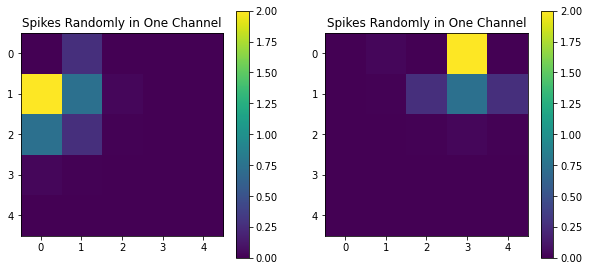

[[0 0 0 0 1]
 [0 1 0 0 0]]


In [7]:
data = np.zeros(3800,dtype = 'float64')
data = np.reshape(data,(2,19,100))
data, y = spiked_channels(data,2,1).forward()
data = data[:,:,1]

plt.figure(figsize = (10,10))


plt.subplot(2, 2, 1)

v_data = np.zeros((2,25))
v_data[:,5:20] = data[:,2:17]
v_data[:,1] = data[:,0]
v_data[:,3] = data[:,1]
v_data[:,21] = data[:,17]
v_data[:,23] = data[:,18]

v_data1 = np.reshape(v_data[0],(5,5))
plt.imshow(v_data1)
plt.title('Spikes Randomly in One Channel')
cbar = plt.colorbar()

plt.subplot(2, 2, 2)
v_data2 = np.reshape(v_data[1],(5,5))
plt.imshow(v_data2)
plt.title('Spikes Randomly in One Channel')
cbar = plt.colorbar()
plt.savefig('spiked_channels_image.png',bbox_inches = 'tight')
plt.show()
print(y)

In [8]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 14.5 MB/s 


DataLoader

In [9]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'W':
          y = np.array([1,0,0,0,0])
        elif y == '1':
          y = np.array([0,1,0,0,0])
        elif y == '2':
          y = np.array([0,0,1,0,0])   
        elif y == '3':
          y = np.array([0,0,0,1,0])
        elif y == '4':
          y = np.array([0,0,0,0,1])      
        return y  

    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

    def __len__(self):
        return self.data_adress[-1]


In [10]:
class MASS_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # self.freq = 1.28 # 256Hz / 1.28 = 200Hz
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
      
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
    def __len__(self):
        return self.data_adress[-1]

Concatenate datasets

In [11]:
from sklearn.model_selection import train_test_split

class concat_dataset():
    def __init__(self, data_dic,seq_len):
        self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
        self.seq_len = seq_len
    
    def tr_val_te_split(self,data_list):
        train, test = train_test_split(data_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
        train, val = train_test_split(train, test_size= 0.25)#, shuffle=True, random_state=34)
        del data_list
        print('split done')
        return train, val, test    
    
    def call(self):
    
        for name, data_list in self.data_dic.items():
            print(name)
            tr, val, te = self.tr_val_te_split(data_list)
            
            if name =='Sleep_edf':
                sleepedf_train_data = Sleepedf_dataset(tr,self.seq_len,SSL = True)
                print('sleep train done')
                sleepedf_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('sleep val done')
                sleepedf_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('sleep test done')
            
            elif name == 'MASS':
                MASS_train_data = Sleepedf_dataset(tr,self.seq_len, SSL = True)
                print('MASS train done')
                MASS_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('MASS val done')
                MASS_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('MASS test done')
    
        train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
        val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
        test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
        return train_dataset, val_dataset, test_dataset

spike

In [12]:
import torch
from torch import nn
from torchsummary import summary as summary_
import os

def model_loader(model_name:str,temporal_len, in_channels, out_channels,FL,KL):
    if model_name == "SpatialNetwork":
        return SpatialNetwork(temporal_len, in_channels, out_channels,FL,KL)

def weight_init_xavier_uniform(submodule):
    if isinstance(submodule, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)
    elif isinstance(submodule, torch.nn.BatchNorm2d):
        submodule.weight.data.fill_(1.0)
        submodule.bias.data.zero_()


class SpatialNetwork(nn.Module):
    def __init__(self,temporal_len):
        super(SpatialNetwork, self).__init__()

        # input length/2 = output of conv1 length
        # self.conv1 = nn.Conv1d(1, 16, stride = 2 ,padding = 14, kernel_size=30) 
        self.conv1 = nn.Conv1d(1, 16, padding = "same", kernel_size=30) 
        self.conv2 = nn.Conv1d(16, 32, padding="same", kernel_size=15)
        self.conv3 = nn.Conv1d(32, 64, padding="same", kernel_size=5)


        self.Spatial_conv_17 = nn.Conv2d(64,64,kernel_size = (17,1)) 
        self.maxpool = nn.MaxPool2d(3, stride=2)


        self.dropout = nn.Dropout(0.5)

        # self.fc = nn.Linear(FL[-1] * 2, 5)
        self.fc = nn.Linear(64*temporal_len, 5)
        self.elu = nn.ELU()
        self.classifier = nn.Softmax(dim=1)
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()

        # xavier initialization
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)

    def embedding1(self, x, b, c):
        # X=(B,C,T)

        # X=(B*C,1,T)
        x = self.elu(self.conv1(x))

        # X=(B*C,F,T2)
        x = self.elu(self.conv2(x))

        # X=(B*C,F,T3)
        x = self.elu(self.conv3(x))
        
        bc,f,t = x.shape 
        x = torch.reshape(x,(b,c,f,t))
        
        # X=(B,F,T4*2) # remove summation part, because each of dataset has a different number of channels
        # x = torch.cat([x.max(dim=1)[0], x.sum(dim=1) / c], dim=1)       
        return x

    def embedding2(self, x, b, c):
        x = self.embedding1(x,b,c)
        b,c,f,t = x.shape
        x = torch.reshape(x,(b,f,c,t))
        if c == 17:
          x = self.elu(self.Spatial_conv_17(x))
          # print(x.shape) # b,64,1,t
          x = torch.squeeze(x)
          # x = self.maxpool(x)
             
        return x    

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        # feature = torch.mean(feature, dim = 2) 
        feature = self.flatten(feature)
        ## feature.shape = [batch,filter]

        feature = self.dropout(feature)
        y_hat = self.softmax(self.fc(feature))
        return y_hat   
    
    def forward(self,x,b,c):
        # print('1:',out.shape)
        x = self.embedding2(x,b,c)
        x = self.classifier(x)
        return x




In [13]:
pip install separableconv-torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# import torch
# from torch import nn
# from torchsummary import summary as summary_
# import separableconv.nn as snn
# import os

# def model_loader(model_name:str,temporal_len, in_channels, out_channels,FL,KL):
#     if model_name == "SpatialNetwork":
#         return SpatialNetwork(temporal_len, in_channels, out_channels,FL,KL)

# class SSL_extractor2(nn.Module):
#     def __init__(self, temporal_len, in_channels, out_channels, FL, KL):
#         super(SSL_extractor2,self).__init__()
#         self.dropout = nn.Dropout(0.3)
#         self.flat=nn.Flatten()
#         self.fc = nn.Linear(FL[-1]*3*temporal_len, 5)
#         self.classifier = nn.Softmax(dim=1)

#     def forward(self,x):
#         out= self.flat(x)
#         out = self.fc(out)
#         out = self.dropout(out)
#         out = self.classifier(out)
#         return out


# class Endcoder2(nn.Module):
#     def __init__(self, temporal_len, in_channels, out_channels, FL, KS):
#         super(Endcoder2, self).__init__()

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.FL = FL

#         self.GAP = nn.AdaptiveAvgPool1d(1)
#         self.GAP2 = nn.AdaptiveAvgPool1d(20)
#         self.dropout = nn.Dropout(0.3)

#         self.sep1 = snn.SeparableConv2d(1, FL[0], (1, KS[0]), padding="same", normalization_dw="bn",
#                                         normalization_pw="bn")
#         self.sep2 = snn.SeparableConv2d(FL[0], FL[1], (1, KS[1]), padding="same", normalization_dw="bn",
#                                         normalization_pw="bn")
#         self.sep3 = snn.SeparableConv2d(FL[1], FL[2], (1, KS[2]), padding="same", normalization_dw="bn",
#                                         normalization_pw="bn")
#         self.pipe = nn.Conv2d(FL[-2], FL[-1], 1, padding="same")

#         self.bn1 = nn.BatchNorm1d(1)
#         self.bn2 = nn.BatchNorm1d(FL[1])

#         self.sep1.apply(weight_init_xavier_uniform)
#         self.sep2.apply(weight_init_xavier_uniform)
#         self.sep3.apply(weight_init_xavier_uniform)

#         self.fc = nn.Linear(FL[-1] * 3 * temporal_len, 5)
#         self.elu = nn.ELU()
#         self.classifier = nn.Softmax(dim=1)
#         self.maxpool = nn.MaxPool1d(2, stride=2)
#         # xavier initialization

#         #   X =(B,C,X,Y)  X =(B,14,T)

#     def forward(self, x):
#         # X=(B,C,T)
#         b_s, c_s, t_s = x.shape
#         x = x.unsqueeze(1)
#         # X=(B*C,1,T)
#         out = self.sep1(x)
#         out = self.elu(out)

#         # X=(B*C,F,T2)
#         out = self.sep2(out)
#         # out= self.bn2(out)
#         out = self.elu(out)

#         # X=(B*C,F,T3)
#         out = self.sep3(out)
#         out = self.elu(out)

#         out = self.pipe(out)
#         out = self.elu(out)

#         # B,C,F*T

#         out = out.view([b_s, c_s, -1])

#         # B,C,F

#         # B,F*T
#         out = torch.cat([out.sum(dim=1), out.max(dim=1)[0], out.sum(dim=1) / self.in_channels], dim=1)
#         out= out.view([b_s,t_s,-1])
#         return out


# class SpatialNetwork2(nn.Module):
#     def __init__(self, temporal_len, in_channels, out_channels, FL, KL):
#         super(SpatialNetwork2, self).__init__()
#         self.encoder = Endcoder2(temporal_len, in_channels, out_channels, FL, KL)
#         self.classifier = SSL_extractor2(temporal_len, in_channels, out_channels,FL,KL)

#     def forward(self,x):
#         out = self.encoder(x)
#         out= self.classifier(out)
#         return out
#     def get_Rep(self,x):
#         out = self.encoder(x)
#         return out

# if __name__ == "__main__":

#     model = SpatialNetwork2(200,23,23,[8,16,32,4],[30,15,5])
#     #model = SpatialNetwork6(7680,14,14,[8,10,12,20])
#     # os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#     # device = "cuda" if torch.cuda.is_available() else "cpu"
#     # print(f"Using {device} device")
#     # model.to(device)
# # 
#     # summary_(model, (23,200), batch_size=322)

In [15]:
import numpy as np
import torch
import torch.nn as nn


# f1acc = f1_score(label, prediction, average='micro')

class PredTaskLoss(torch.nn.modules.loss._Loss):
    def __init__(self, beta, scale, device = None):
        super().__init__()
        self.device = device
        self.beta = beta
        self.scale= scale

    def forward(self, batch, encoder, spiked_channels, train):
        batch_aug, labels = spiked_channels(batch,self.scale,self.beta).forward()
        b,c,t = batch_aug.shape
        batch_aug = np.reshape(batch_aug, (b*c,1,t)) # we use sing channel encoder
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(batch_aug).type(torch.float).to(self.device),b,c) 
        # print('pred:',pred.shape)
        labels = torch.Tensor(labels).to(self.device)
        # print('labels:',labels.shape)

        loss = CrossEL(pred,labels)
        if train:
            loss.backward(retain_graph=True)
        
        _, Y =  torch.max(labels, 1) 
        _, predicted = torch.max(pred, 1) 
        acc = (predicted == Y).sum().item()
        acc = acc/(b)
        # print(acc)
        return loss, acc

In [16]:
import glob

SS1_list = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEG/**')
print(len(SS1_list))
MASS_list = []
for i in range(len(SS1_list)):
    length = len(MASS_list)
    MASS_list.extend(glob.glob(SS1_list[i]+'/**'))
    print(len(MASS_list) - length)
print(len(MASS_list))

1
918
918


In [17]:
train, test = train_test_split(MASS_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
train, val = train_test_split(train, test_size= 0.25)#, shu

In [23]:
train_dataset = MASS_dataset(train, 2000, SSL = True)
val_dataset = MASS_dataset(val, 2000, SSL = True)
test_dataset = MASS_dataset(test, 2000, SSL = True)

In [24]:
import os
import torch
# batch size
batch_size = 100
learning_rate = 0.001
epochs = 15

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"
print(device)

cuda:0


In [25]:
# model = SpatialNetwork2(200,23,23,[8,16,32,4],[30,15,5]).to(device)

model = SpatialNetwork(2000).to(device)
criterion = PredTaskLoss(1,0.5,device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle= True)
valLoader = DataLoader(val_dataset, batch_size = batch_size , shuffle= True)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle= True)


In [27]:
import matplotlib.pyplot as plt
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        # print(batch.shape)
        optimizer.zero_grad()
        loss_batch, acc_batch = criterion.forward(batch, model, spiked_channels,train = True)
        # print(batch_idx)
        optimizer.step()
        loss_ep += loss_batch.item()
        # print('loss:',loss_batch.item())
        # print(acc_batch)
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0
    for batch_idx, batch in enumerate(valLoader):
        loss_batch_val, acc_batch_val = criterion.forward(batch, model,spiked_channels, train = False)
        loss_ep_val += loss_batch_val.item()
        acc_ep_val += acc_batch_val
    
    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'Spike_10s_ep' + str(epoch)+'_.pt')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  1.3137980033369625 train acc :  0.5776470588235295     val loss :  0.9825969040393829 val acc :  0.9207692307692309
epoch :  1   train loss :  0.9932167284628924 train acc :  0.9105882352941177     val loss :  0.9809651076793671 val acc :  0.9237179487179489
epoch :  2   train loss :  0.9782801270484924 train acc :  0.9264705882352943     val loss :  0.9873478909333547 val acc :  0.9171794871794873
epoch :  3   train loss :  0.9849621653556824 train acc :  0.9194117647058824     val loss :  0.9884183605511984 val acc :  0.9161538461538461
epoch :  4   train loss :  0.9874531346208909 train acc :  0.9170588235294117     val loss :  1.0019030570983887 val acc :  0.9026923076923077
epoch :  5   train loss :  0.9887086293276619 train acc :  0.9158823529411764     val loss :  0.9597160518169403 val acc :  0.9452564102564103
epoch :  6   train loss :  0.9769713282585144 train acc :  0.9270588235294118     val loss :  0.981013019879659 val acc :  0.9237179487179489


result save and plot

In [28]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('spike_10s.xlsx', index = False)

(4, 15)


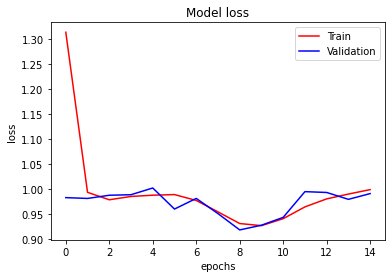

In [29]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('spike_loss_10s',bbox_inches = 'tight')
plt.show()


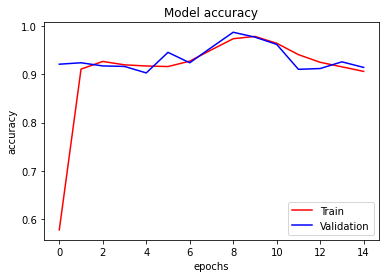

In [30]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('spike_accuracy_10s',bbox_inches = 'tight')
plt.show()

In [ ]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [ ]:
torch.save(model,'Spatial__10s.pt')

In [ ]:
torch.save(model.state_dict(),'Spectral_20s_stat_dict.pt')